# 1. Загрузка данных

In [1]:
import numpy as np
import scipy
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

Загружаем набор данных

In [2]:
df = pd.read_csv("data_popular.csv")

Проверяем его

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4901 entries, 0 to 4900
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Название  4901 non-null   object 
 1   Описание  4901 non-null   object 
 2   Оценка    4901 non-null   float64
dtypes: float64(1), object(2)
memory usage: 115.0+ KB


In [4]:
df

,Название,Описание,Оценка
0,Death Note,Изнывающий от скуки Синигами Рюк бросает одну ...,8.63
1,Shingeki no Kyojin,С давних времён человечество ведёт свою борьбу...,8.49
2,Fullmetal Alchemist: Brotherhood,Ремейк одноимённого аниме-сериала «Стальной ал...,9.17
3,Sword Art Online,И вот вышла многопользовательская игра нового ...,7.24
4,One Punch Man,Вы устали от запоминания суператак и бесконечн...,8.56
...,...,...,...
4896,Eikou e no Spur: Igaya Chiharu Monogatari,Анимационная биография японского горнолыжника ...,0.00
4897,Nippon Tanjou,Мультфильм в общих чертах рассказывает об исто...,0.00
4898,Si Ling Bianma: Zhi Shijie Caozong Zhe Recap,Краткий пересказ событий первых десяти серий а...,0.00
4899,Otogi Banashi: Bunbuku Chagama,Фильм снят по мотивам японской народной сказки...,0.00


Проверяем значение оценок

In [5]:
df["Оценка"].value_counts()

0.00    98
7.35    43
7.32    38
7.27    35
7.28    33
        ..
8.70     1
3.88     1
2.98     1
5.21     1
8.65     1
Name: Оценка, Length: 446, dtype: int64

Отбразываем произведения без оценки

In [6]:
df['Оценка'] = df['Оценка'].replace({0.0: np.nan})
df = df.dropna().reset_index(drop=True)

In [7]:
df["Оценка"].value_counts()

7.35    43
7.32    38
7.27    35
7.28    33
7.55    32
        ..
8.70     1
3.88     1
5.21     1
2.98     1
3.99     1
Name: Оценка, Length: 445, dtype: int64

Смотрим на конечный набор данных 

In [8]:
df

,Название,Описание,Оценка
0,Death Note,Изнывающий от скуки Синигами Рюк бросает одну ...,8.63
1,Shingeki no Kyojin,С давних времён человечество ведёт свою борьбу...,8.49
2,Fullmetal Alchemist: Brotherhood,Ремейк одноимённого аниме-сериала «Стальной ал...,9.17
3,Sword Art Online,И вот вышла многопользовательская игра нового ...,7.24
4,One Punch Man,Вы устали от запоминания суператак и бесконечн...,8.56
...,...,...,...
4798,Sword of Phantasia,Презентация мобильной игры «Sword of Phantasia...,5.70
4799,Drive Agent Personal: Shiawase wo Mamoru Mono,Реклама видеорегистратора для автомобилей.,5.87
4800,Bouningen Weekend,Коротенькие зарисовки повседневной жизни котик...,5.35
4801,"Eiga Ensetsu ""Seiji no Rinrika"" Gotou Shinpei ...",Анимационное отображение политической идеологи...,5.40


# 2. Предоботка данных

In [9]:
# !pip install pymorphy2

In [10]:
# !pip install -U pymorphy2-dicts-ru

In [11]:
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2.1. Токенизация текста

Так как нейросети могут работать только с числовыми значениями, необходимо преобразовать текстовое описание в числа.

Составим частотынй словарь и заменим слова их числовыми значениями.

In [12]:
# Выделяем из данных описания
description = df['Описание']

### 2.1.1. Работа с лексемами

https://pymorphy2.readthedocs.io/en/stable/

Так как мы работаем с русским языком, то наличие падежей/склонений/времён не дадут нам посчитать схожие слова вместе. Например слова "слон" и "слонов" токенизатор посчитает за разные слова. Кроме того, служебные слова ("и", "в", "на" и пр.) никакой смысловой нагрузки не несут. Так что перед тем, как составлять частотный словарь нам нужно:
1. Откинуть служебные слова
2. Откинуть лишние символы
3. Привести слова к нормальной форме

In [13]:
import pymorphy2

# функция преобразования текста: преведение форм слов к нормальным, фильтрация знаков припинания и отбрасывание служебных слов 
def text_filter(text):
    morph = pymorphy2.MorphAnalyzer()
    sequence = text_to_word_sequence(text, filters="!«»#$%&()*+,-—–./:;<=>?@[\\]^_`{|}~\t\n")
#     sequence = text.split(" ")
    new_sequence = []
    
    for word in sequence:
        # берём инормацию о слове и его первую нормальную форму
        p = morph.parse(word)[0]
        # откидываем служебные слова: предлог, союз, частица, междометие 
        if 'PREP' in p.tag or 'CONJ' in p.tag or 'PRCL' in p.tag or 'INTJ' in p.tag:
            continue
        # откидываем неизвестные токены, римские и дробные цифры (целые могут обозначать год) и знаки пунктуации
        if 'PREP' in p.tag or 'ROMN' in p.tag or 'real' in p.tag or 'PNCT' in p.tag:
            continue
        # откидываем числа, не являющиеся годом
        if 'intg' in p.tag and (len(word) != 3 and len(word) != 4):
            continue
        # остальные слова приводим к нормальной форме
        new_sequence.append(p.normal_form)
        
    new_text = " ".join(new_sequence)
#     print("done")
    
    return new_text
        

Посмотрим на пример того, как функция преобразовывает текст:

In [14]:
description[8]

'Действие сериала происходит летом 2010 года в Акихабаре. Группа друзей переделывает микроволновку в некое устройство, способное посылать текстовые сообщения в прошлое. Пока они проводят над устройством различные эксперименты, ими заинтересовывается таинственная организация SERN, которая также проводит исследования по путешествиям во времени. SERN начинает преследовать друзей, и теперь главным героям предстоит найти способ не быть захваченными ими.'

In [15]:
text_filter(description[8])

'действие сериал происходить лето 2010 год акихабара группа друг переделывать микроволновка некий устройство способный посылать текстовый сообщение прошлое пока они проводить устройство различный эксперимент они заинтересовываться таинственный организация sern который проводить исследование путешествие время sern начинать преследовать друг теперь главный герой предстоять найти способ быть захватить они'

Теперь применим функцию для всех текстов

In [16]:
# normalize_description = description.apply(text_filter)

Проверим результат

In [17]:
# normalize_description[0]

Т.к. преобразование текста занимает продолжительное время, сохраним полученный результат для дальнейшей загрузки

In [18]:
# normalize_df = df.copy()
# normalize_df['Описание'] = normalize_description

In [19]:
# normalize_df

Сохраняем

In [20]:
# normalize_df.to_csv("normalize_data_popular.csv", sep=',', encoding='utf-8', index=False)

В случае, если уже есть готовый файл - загружаем

In [21]:
normalize_df = pd.read_csv("normalize_data_popular.csv")

Просматриваем на коректность

In [22]:
# normalize_df

In [23]:
normalize_description = normalize_df["Описание"]
# normalize_description = df["Описание"]

### 2.1.2. Применение токенизации

In [24]:
# Задаём гиперпараметры 
num_words = 10000 # Количество слов в словаре
max_review_len = 50 # Фиксированная длина описания

Создаем токенизатор Keras (состовляющий словарь слов по их частоте)

In [25]:
tokenizer = Tokenizer(num_words=num_words, # максимальное количество слов в словаре
                      filters="!«»#$%&()*+,-—–./:;<=>?@[\\]^_`{|}~\t\n", # фильтр отбрасываемых символов 
#                       oov_token = num_words + 1 # токен для слов, не вошедших в словарь
                     )

Обучаем токенизатор на отзывах

In [26]:
tokenizer.fit_on_texts(normalize_description)

Просматриваем первых 15 слов из словаря токенизатора

In [27]:
len(tokenizer.word_index.keys())

25441

In [28]:
tokenizer.word_index['sern']

10192

In [29]:
# tokenizer.word_index
for token, ind in tokenizer.word_index.items():
    print(f"\"{token}\" : {ind}")
    if ind == 15: break 

"он" : 1
"который" : 2
"они" : 3
"свой" : 4
"она" : 5
"быть" : 6
"тот" : 7
"мир" : 8
"человек" : 9
"этот" : 10
"девушка" : 11
"жизнь" : 12
"её" : 13
"один" : 14
"весь" : 15


Преобразуем описания в числовое представление

In [30]:
sequences = tokenizer.texts_to_sequences(normalize_description)

Просматриваем отзывы в числовом представлении

In [31]:
print(normalize_description[8])
print(sequences[8])

действие сериал происходить лето 2010 год акихабара группа друг переделывать микроволновка некий устройство способный посылать текстовый сообщение прошлое пока они проводить устройство различный эксперимент они заинтересовываться таинственный организация sern который проводить исследование путешествие время sern начинать преследовать друг теперь главный герой предстоять найти способ быть захватить они
[192, 29, 78, 750, 3600, 19, 5626, 102, 18, 399, 1372, 172, 1580, 1923, 244, 163, 3, 279, 1372, 339, 1141, 3, 94, 160, 2, 279, 1250, 206, 16, 54, 503, 18, 44, 56, 30, 92, 72, 548, 6, 626, 3]


Ограничиваем длину отзывов.



Отзывы больше, чем max_review_len, обрезаются; а те, что меньше - дополняются нулями в начало (для лучшей работы рекурсивных нейронных сетей).

In [32]:
sequences_cut = pad_sequences(sequences, maxlen=max_review_len)

In [33]:
sequences_cut[8]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,  192,   29,
         78,  750, 3600,   19, 5626,  102,   18,  399, 1372,  172, 1580,
       1923,  244,  163,    3,  279, 1372,  339, 1141,    3,   94,  160,
          2,  279, 1250,  206,   16,   54,  503,   18,   44,   56,   30,
         92,   72,  548,    6,  626,    3])

## 2.2. Создание выборок

In [34]:
from sklearn.model_selection import train_test_split

Разделим данные на обучающую и тестовую выборку. Данные преобразуем в numpy массивы, с которыми работает Keras

In [35]:
x = sequences_cut
y = df['Оценка'].to_numpy()

Так как данных достаточно немного, то для тестовой выборки возьмём лишь 15% от исходной

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [37]:
x_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  786,  352,  267,    6,  925,   23,
        106,  123,  196,  345,   53, 2798,   29,    5,    6,  228,   30,
        975,  614,  134,  786,  352,  267,    6,  925,   23,  106,  123,
        159, 3321, 2822, 1700,  146,  131])

In [38]:
y_train[1]

7.07

# 3. Работа с нейросетью

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, GRU, Dropout

In [39]:
np.random.seed(1337)  # для воспроизводимости сети

In [40]:
def visualization_history(history):
    plt.plot(history.history['mean_absolute_percentage_error'],
             label='% отклонения от ответов на обучающем наборе')
    plt.plot(history.history['val_mean_absolute_percentage_error'],
         label='% отклонения от ответов на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Процент отклонения от ответов')
    plt.legend()
    plt.show()

# 3.1 Нейросеть прямого распространения

Для начала созданим checkpoint, с помощью которого будем сохранять веса самой лучшей модели

In [158]:
dense_save_path = 'best_dense.h5'
dense_checkpoint_callback = ModelCheckpoint(dense_save_path, 
                                      monitor='val_mean_absolute_percentage_error',
                                      save_best_only=True,
                                      verbose=1)

Создадим самую простую нейросеть с несколькими слоями:
1. Входной слой размером 50 (длина отзыва)
2. Слой для представления текста плотными векторами (embeddings) (настраивается в процессе обучения и строит вектор слов, разделённых для конкретной задачи)
3. 2 слоя прямого распространения с активационной функцией ReLu (каждый нейрон соединён с каждым)
4. Выходной слой с активационной функцией linear (т.к. задача регрессии)

In [159]:
dense = Sequential()
dense.add(Embedding(num_words, 64, input_length=max_review_len))
dense.add(Dense(128, activation='relu'))
dense.add(Dense(64, activation='relu'))
dense.add(Dense(1, activation='linear'))

In [160]:
dense.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_percentage_error','mean_absolute_error'])

In [161]:
dense_history = dense.fit(x_train, 
                    y_train,
                    epochs=25,
                    batch_size=400,
                    validation_split=0.1,
                    callbacks=[dense_checkpoint_callback])

Epoch 1/25
10/10 [==============================] - 1s 51ms/step - loss: 47.8174 - mean_absolute_percentage_error: 98.7341 - mean_absolute_error: 6.8641 - val_loss: 45.5243 - val_mean_absolute_percentage_error: 96.5801 - val_mean_absolute_error: 6.6933

Epoch 00001: val_mean_absolute_percentage_error improved from inf to 96.58011, saving model to best_dense.h5
Epoch 2/25
10/10 [==============================] - 0s 38ms/step - loss: 43.7461 - mean_absolute_percentage_error: 94.2545 - mean_absolute_error: 6.5589 - val_loss: 39.4939 - val_mean_absolute_percentage_error: 89.6292 - val_mean_absolute_error: 6.2231

Epoch 00002: val_mean_absolute_percentage_error improved from 96.58011 to 89.62923, saving model to best_dense.h5
Epoch 3/25
10/10 [==============================] - 0s 38ms/step - loss: 35.5866 - mean_absolute_percentage_error: 84.4769 - mean_absolute_error: 5.8933 - val_loss: 27.5439 - val_mean_absolute_percentage_error: 73.8262 - val_mean_absolute_error: 5.1550

Epoch 00003: va

10/10 [==============================] - 0s 34ms/step - loss: 0.6199 - mean_absolute_percentage_error: 9.3286 - mean_absolute_error: 0.6099 - val_loss: 0.9162 - val_mean_absolute_percentage_error: 10.5660 - val_mean_absolute_error: 0.6795

Epoch 00024: val_mean_absolute_percentage_error did not improve from 10.53285
Epoch 25/25
10/10 [==============================] - 0s 38ms/step - loss: 0.6199 - mean_absolute_percentage_error: 9.3205 - mean_absolute_error: 0.6108 - val_loss: 0.9152 - val_mean_absolute_percentage_error: 10.5505 - val_mean_absolute_error: 0.6806

Epoch 00025: val_mean_absolute_percentage_error did not improve from 10.53285


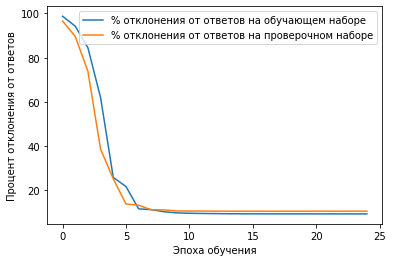

In [162]:
visualization_history(dense_history)

In [163]:
dense.load_weights(dense_save_path)

In [164]:
scores_dense = dense.evaluate(x_test, y_test)

23/23 [==============================] - 0s 3ms/step - loss: 0.9749 - mean_absolute_percentage_error: 11.0303 - mean_absolute_error: 0.7184


## 3.2 Рекурентная нейросеть

Создадим рекурсивную нейросеть с несколькими слоями:
1. Входной слой размером 50 (длина отзыва)
2. Слой для представления текста плотными векторами (embeddings) (настраивается в процессе обучения и строит вектор слов, разделённых для конкретной задачи
3. Рекурентный слой слой
4. Выходной слой с активационной функцией linear (т.к. задача регрессии)

In [165]:
rnn_save_path = 'best_rnn.h5'
rnn_checkpoint_callback = ModelCheckpoint(rnn_save_path, 
                                      monitor='val_mean_absolute_percentage_error',
                                      save_best_only=True,
                                      verbose=1)

In [166]:
rnn = Sequential()
rnn.add(Embedding(num_words, 48, input_length=max_review_len))
rnn.add(SimpleRNN(48))
rnn.add(Dense(1, activation='linear'))

In [167]:
rnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_percentage_error','mean_absolute_error'])

In [168]:
rnn_history = rnn.fit(x_train, 
                    y_train,
                    epochs=25,
                    batch_size=400,
                    validation_split=0.1,
                    callbacks=[rnn_checkpoint_callback])

Epoch 1/25
10/10 [==============================] - 1s 53ms/step - loss: 40.2603 - mean_absolute_percentage_error: 90.0543 - mean_absolute_error: 6.2719 - val_loss: 28.2287 - val_mean_absolute_percentage_error: 75.3070 - val_mean_absolute_error: 5.2454

Epoch 00001: val_mean_absolute_percentage_error improved from inf to 75.30696, saving model to best_rnn.h5
Epoch 2/25
10/10 [==============================] - 0s 37ms/step - loss: 21.4556 - mean_absolute_percentage_error: 64.6161 - mean_absolute_error: 4.5315 - val_loss: 13.0224 - val_mean_absolute_percentage_error: 49.7655 - val_mean_absolute_error: 3.5084

Epoch 00002: val_mean_absolute_percentage_error improved from 75.30696 to 49.76549, saving model to best_rnn.h5
Epoch 3/25
10/10 [==============================] - 0s 36ms/step - loss: 9.3176 - mean_absolute_percentage_error: 41.1238 - mean_absolute_error: 2.9183 - val_loss: 5.2107 - val_mean_absolute_percentage_error: 30.2779 - val_mean_absolute_error: 2.1539

Epoch 00003: val_mean

10/10 [==============================] - 0s 34ms/step - loss: 0.6457 - mean_absolute_percentage_error: 9.6677 - mean_absolute_error: 0.6341 - val_loss: 0.7135 - val_mean_absolute_percentage_error: 10.0359 - val_mean_absolute_error: 0.6424

Epoch 00024: val_mean_absolute_percentage_error did not improve from 10.03485
Epoch 25/25
10/10 [==============================] - 0s 36ms/step - loss: 0.6379 - mean_absolute_percentage_error: 9.6112 - mean_absolute_error: 0.6300 - val_loss: 0.7135 - val_mean_absolute_percentage_error: 10.0368 - val_mean_absolute_error: 0.6423

Epoch 00025: val_mean_absolute_percentage_error did not improve from 10.03485


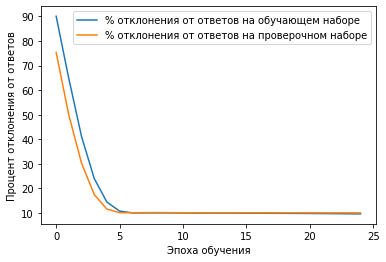

In [169]:
visualization_history(rnn_history)

In [170]:
rnn.load_weights(rnn_save_path)

In [171]:
scores_rnn = rnn.evaluate(x_test, y_test)

23/23 [==============================] - 0s 3ms/step - loss: 0.7578 - mean_absolute_percentage_error: 10.5382 - mean_absolute_error: 0.6804


## 3.3 Рекуррентная нейронная сеть GRU

Создадим рекурсивную нейросеть с несколькими слоями:
1. Входной слой размером 50 (длина отзыва)
2. Слой для представления текста плотными векторами (embeddings) (настраивается в процессе обучения и строит вектор слов, разделённых для конкретной задачи
3. Рекурсивный слой LSTM
4. Выходной слой с активационной функцией linear (т.к. задача регрессии)

In [322]:
gru_save_path = 'best_gru.h5'
gru_checkpoint_callback = ModelCheckpoint(gru_save_path, 
                                      monitor='val_mean_absolute_percentage_error',
                                      save_best_only=True,
                                      verbose=1)

In [323]:
gru = Sequential()
gru.add(Embedding(num_words, 48, input_length=max_review_len))
gru.add(GRU(144))
gru.add(Dropout(0.2))
gru.add(Dense(1, activation='linear'))

In [324]:
gru.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_percentage_error','mean_absolute_error'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл best_model.h5

In [325]:
gru_history = gru.fit(x_train, 
                    y_train,
#                     np.stack(np.vectorize(lambda x: x / 10)(y_train), axis=0),
                    epochs=20,
                    batch_size=400,
                    validation_split=0.1,
                    callbacks=[gru_checkpoint_callback])

Epoch 1/20
10/10 [==============================] - 3s 206ms/step - loss: 46.7493 - mean_absolute_percentage_error: 97.5915 - mean_absolute_error: 6.7853 - val_loss: 39.5914 - val_mean_absolute_percentage_error: 89.8500 - val_mean_absolute_error: 6.2349

Epoch 00001: val_mean_absolute_percentage_error improved from inf to 89.85004, saving model to best_gru.h5
Epoch 2/20
10/10 [==============================] - 2s 175ms/step - loss: 18.3798 - mean_absolute_percentage_error: 55.1958 - mean_absolute_error: 3.7919 - val_loss: 4.7958 - val_mean_absolute_percentage_error: 28.7963 - val_mean_absolute_error: 2.0500

Epoch 00002: val_mean_absolute_percentage_error improved from 89.85004 to 28.79632, saving model to best_gru.h5
Epoch 3/20
10/10 [==============================] - 2s 182ms/step - loss: 2.6579 - mean_absolute_percentage_error: 20.1020 - mean_absolute_error: 1.3601 - val_loss: 0.8620 - val_mean_absolute_percentage_error: 11.3117 - val_mean_absolute_error: 0.6924

Epoch 00003: val_me

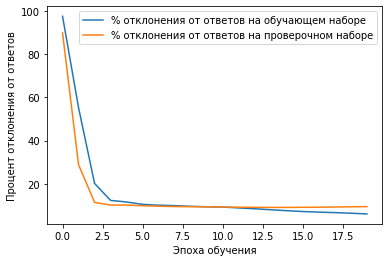

In [326]:
visualization_history(gru_history)

In [327]:
gru.load_weights(gru_save_path)

In [328]:
# best_model.load_weights("best_model.h5")

In [329]:
scores_gru = gru.evaluate(x_test, y_test)

23/23 [==============================] - 0s 12ms/step - loss: 0.6484 - mean_absolute_percentage_error: 9.5570 - mean_absolute_error: 0.6266


# 4. Сравнение моделей

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns

Для сравнения результативности используем гистограммы

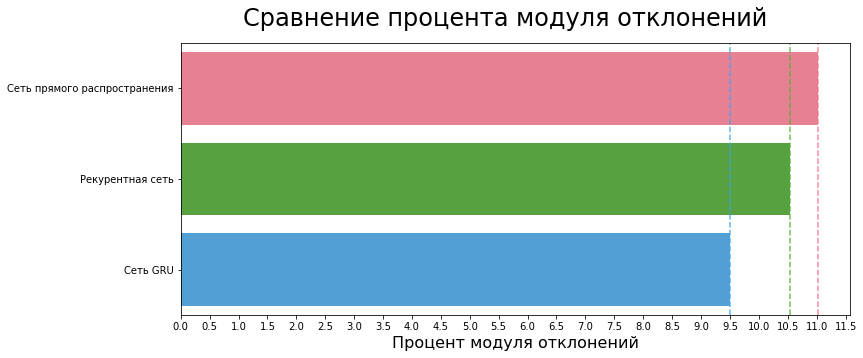

In [269]:
fig, ax = plt.subplots(1, 1)
sns.barplot(y=['Сеть прямого распространения', 'Рекурентная сеть', 'Сеть GRU'],
            x=[scores_dense[1], scores_rnn[1], scores_gru[1]], ax=ax, palette = sns.color_palette("husl", 9)[0:10:3]);
# ax.set_ylabel("Тип сети", fontsize = 16)
ax.set_xlabel("Процент модуля отклонений", fontsize = 16)

plt.axvline(scores_dense[1], color=sns.color_palette("husl", 9)[0], alpha=0.8, linestyle='dashed')
plt.axvline(scores_rnn[1], color=sns.color_palette("husl", 9)[3], alpha=0.8, linestyle='dashed')
plt.axvline(scores_gru[1], color=sns.color_palette("husl", 9)[6], alpha=0.8, linestyle='dashed')
fig.set_figwidth(12)
fig.set_figheight(5)
fig.suptitle("Сравнение процента модуля отклонений", fontsize=24)
plt.xticks(np.arange(0, 12, step=0.5))
plt.show()

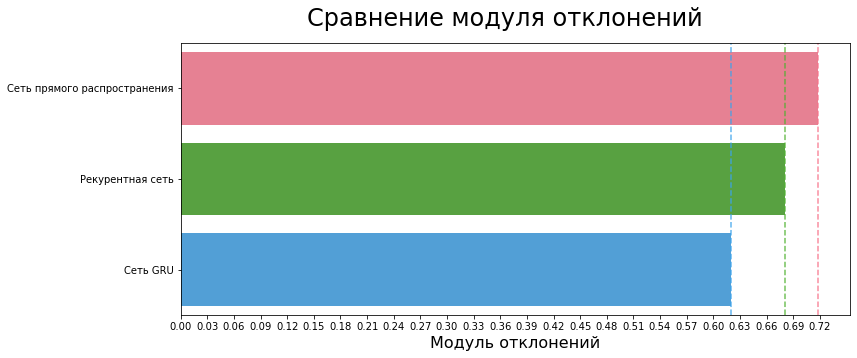

In [272]:
fig, ax = plt.subplots(1, 1)
sns.barplot(y=['Сеть прямого распространения', 'Рекурентная сеть', 'Сеть GRU'],
            x=[scores_dense[2], scores_rnn[2], scores_gru[2]], ax=ax, palette = sns.color_palette("husl", 9)[0:10:3]);
# ax.set_ylabel("Тип сети", fontsize = 16)
ax.set_xlabel("Модуль отклонений", fontsize = 16)

plt.axvline(scores_dense[2], color=sns.color_palette("husl", 9)[0], alpha=0.8, linestyle='dashed')
plt.axvline(scores_rnn[2], color=sns.color_palette("husl", 9)[3], alpha=0.8, linestyle='dashed')
plt.axvline(scores_gru[2], color=sns.color_palette("husl", 9)[6], alpha=0.8, linestyle='dashed')
fig.set_figwidth(12)
fig.set_figheight(5)
fig.suptitle("Сравнение модуля отклонений", fontsize=24)
plt.xticks(np.arange(0, 0.75, step=0.03))
plt.show()

# 5 Пример работы

Выбираем лучшую модель

In [332]:
model = gru

Проверим эффективность предсказания на аниме, которое не учавствовало в обучении

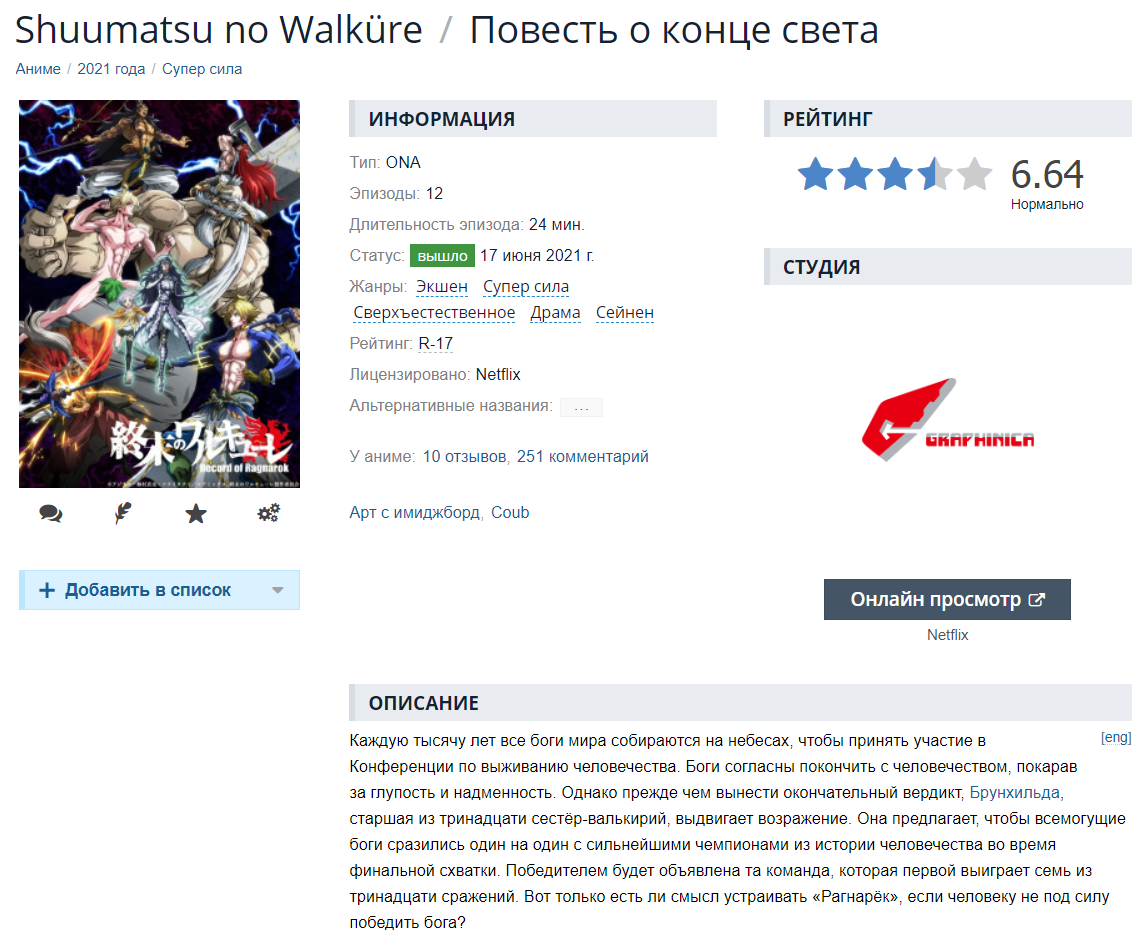

Проверяем, что аниме нет в обучающем списке

In [62]:
df['Описание'].str.contains("Повесть о конце света").value_counts()

False    4803
Name: Описание, dtype: int64

In [63]:
df['Описание'].str.contains("Shuumatsu no Walküre").value_counts()

False    4803
Name: Описание, dtype: int64

Как видно, его там действительно нет

Предобрабатываем описание

In [64]:
descript = "Каждую тысячу лет все боги мира собираются на небесах, чтобы принять участие в Конференции по выживанию человечества. Боги согласны покончить с человечеством, покарав за глупость и надменность. Однако прежде чем вынести окончательный вердикт, Брунхильда, старшая из тринадцати сестёр-валькирий, выдвигает возражение. Она предлагает, чтобы всемогущие боги сразились один на один с сильнейшими чемпионами из истории человечества во время финальной схватки. Победителем будет объявлена та команда, которая первой выиграет семь из тринадцати сражений. Вот только есть ли смысл устраивать «Рагнарёк», если человеку не под силу победить бога?"

In [65]:
text = text_filter(descript)

In [66]:
seq = tokenizer.texts_to_sequences([text])

In [67]:
seq_cut = pad_sequences(seq, maxlen=max_review_len)

Выполняем предсказание

In [333]:
pred_score = model.predict(seq_cut)[0][0]

In [335]:
print(round(pred_score,2))

6.86
